In [ ]:
rm(list = ls())
gc()

setwd("/mnt/data00/minghui/project_NMF/06_Test_NMF_Program_0213/")
library(Seurat)
library(dplyr)
library(cowplot)
library(harmony)
library(readr) 
library(tidyr)
library(gplots)
library(reshape2)
library(paletteer)
library(AUCell)
library(pheatmap)
suppressPackageStartupMessages(library(NMF))
suppressMessages(library(ggplot2))
suppressMessages(library(tidyverse))
suppressMessages(library(scibet))
suppressMessages(library(viridis))
suppressMessages(library(ggsci))
 
d_palettes<- palettes_d_names
mycol<-paletteer_d( "ggsci::default_igv",n=51)

# source('../Fuctions/Markers_kno.R')
# source('../Fuctions/seurat_functions.R')

library(ComplexHeatmap)
library(circlize)

library(scater)


library(htmlwidgets)

library(GSVA)

library(corrplot)


library(patchwork)


In [ ]:
AllTissue_merge <-readRDS('../02_NMFAllTissue/03_AllTissue_merge.rds')

Healthy_modules <-readRDS('./01_Healthy_modules.rds')

In [7]:
BE_modules <-readRDS("/mnt/data00/minghui/project_NMF/04_Test_NMF_Program_0120/01_BE_modules.rds")

names(BE_modules) <- paste0("BE_module", seq_along(BE_modules))

BE_modules <- Filter(function(x) length(x) > 3, BE_modules)

In [ ]:
AllTissue_merge_Healthy <-  AddModuleScore(AllTissue_merge,
                       features = Healthy_modules,
                       ctrl = 100,
                       name = "Healthy_module")

Healthy_modules_score <- AllTissue_merge_Healthy@meta.data[,names(Healthy_modules)]

dim(Healthy_modules_score)

AllTissue_merge_BE <-  AddModuleScore(AllTissue_merge,
                       features = BE_modules,
                       ctrl = 100,
                       name = "BE_module")

BE_modules_score <- AllTissue_merge_BE@meta.data[,c('Tissue_in_paper', 'Detailed_Cell_Type',colnames(AllTissue_merge_BE@meta.data)[grepl('BE_module',colnames(AllTissue_merge_BE@meta.data) )])]

dim(BE_modules_score)

### UMAP

In [16]:
  # get  reduction from seurat obj
  umap <- AllTissue_merge_Healthy@reductions[['umap']]@cell.embeddings
  x_name <- colnames(umap)[1]
  y_name <- colnames(umap)[2]

In [17]:
plot_df <- cbind(umap, Healthy_modules_score) %>% as.data.frame()
plot_df<- plot_df[sample(1:nrow(plot_df),size = 0.2*nrow(plot_df)),]

In [20]:
c(names(BE_modules),names(Healthy_modules)) %>%length

[1] 33

In [32]:
mycolor <- c('#D916F2','#27A4F2','#F2CB05','#F29F05','#F25C05',
             
             '#D94169','#171559','#F2D0A7','#F29F80','#F26363',
             
             '#B3A815', '#1FC7FF','#FFF005','#FF1F59','#FFD3B6',
             
             '#DCEDC1', '#F24B88','#A8E6CF','#660373','#F28A80'
)


# be_colors <- scales::seq_gradient_pal('#fef5f0', "#990F0F")(seq(0, 1, length.out = sum(grepl("^BE_module", rownames(radar_plot_df)))))

# healthy_colors <- scales::seq_gradient_pal("#cac5e4", "#260F99")(seq(0, 1, length.out = sum(grepl("^Healthy", rownames(radar_plot_df)))))
 
# colors <- c(healthy_colors , be_colors)
colors <- data.frame('modules' =names(Healthy_modules) ,'colors' =mycolor[1:length(Healthy_modules)])

In [33]:
length(Healthy_modules)

[1] 16

In [34]:
colors

modules,colors
<chr>,<chr>
Healthy_module1,#D916F2
Healthy_module2,#27A4F2
Healthy_module3,#F2CB05
Healthy_module4,#F29F05
Healthy_module5,#F25C05
Healthy_module6,#D94169
Healthy_module7,#171559
Healthy_module8,#F2D0A7
Healthy_module9,#F29F80


In [35]:
umap_theme <- function(){
  theme(
    axis.line=element_blank(),
    axis.text.x=element_blank(),
    axis.text.y=element_blank(),
    axis.ticks=element_blank(),
    axis.title.x=element_blank(),
    axis.title.y=element_blank(),
    panel.background=element_blank(),
    panel.border=element_blank(),
    panel.grid.major=element_blank(),
    panel.grid.minor=element_blank(),
    plot.background=element_blank(),
    plot.title = element_text(hjust = 0.5)
  )
}


In [36]:
#   plot_list <- list()
restrict_range = FALSE
order_points = FALSE
title=TRUE
point_size = 0.2
alpha=1
label_legend = FALSE
ucell = FALSE
raster=TRUE
raster_dpi=500
raster_scale=1
plot_ratio = 1
title=TRUE

In [37]:
plot_list <- list()

  for(cur_mod in names(Healthy_modules)){

    print(cur_mod)

    # get the color for this module:
    cur_color <- colors %>% subset(modules == cur_mod) %>% .$colors %>% unique

    # reset the range of the plot:
    plot_range <- plot_df[,cur_mod] %>% range
    if(restrict_range){
      if(abs(plot_range[1]) > abs(plot_range[2])){
        plot_range[1] <- -1*plot_range[2]
      } else{
        plot_range[2] <- -1*plot_range[1]
      }
      plot_df[,cur_mod] <- ifelse(plot_df[,cur_mod] > plot_range[2], plot_range[2], plot_df[,cur_mod])
      plot_df[,cur_mod] <- ifelse(plot_df[,cur_mod] < plot_range[1], plot_range[1], plot_df[,cur_mod])
    }

    cur_plot_df <- plot_df[,c(colnames(umap), cur_mod)]
    colnames(cur_plot_df)[3] <- "val"

    # order points:
    if(order_points == TRUE){
      cur_plot_df <- cur_plot_df %>% dplyr::arrange(val)
    } else if(order_points == "shuffle"){
      cur_plot_df <- cur_plot_df[sample(nrow(cur_plot_df)),]
    }

    # plot with ggplot
    p <- cur_plot_df %>%
      ggplot(aes_string(x=x_name, y=y_name, color="val"))

    # rasterise?
    if(raster){
      p <- p + ggrastr::rasterise(geom_point(size=point_size, alpha=alpha), dpi=raster_dpi, scale=raster_scale)
    } else{
      p <- p + geom_point(size=point_size, alpha=alpha)
    }

    # add title and theme:
    p <- p + umap_theme() + labs(color="")

    if(title){
      p <- p + ggtitle(cur_mod)
    }

    # aspect ratio:
    if(is.numeric(plot_ratio)){
      p <- p + coord_fixed(ratio = plot_ratio)
    }

    # UCell?
    if(!ucell){
      p <- p + scale_color_gradient2(
        low='grey75', mid='grey95', high=cur_color,
        breaks = plot_range,
        labels = c('-', '+'),
        guide = guide_colorbar(ticks=FALSE, barwidth=0.5, barheight=4)
      )
    } else{
      p <- p + scale_color_gradient(
        low='grey95', high=cur_color,
        breaks = plot_range,
        labels = c('0', '+'),
        guide = guide_colorbar(ticks=FALSE, barwidth=0.5, barheight=4)
      )
    }
    plot_list[[cur_mod]] <- p

  }

  # return plot
  if(length(plot_list) == 1){
    p <- plot_list[[1]]
  } else{
    p <- plot_list
  }





[1] "Healthy_module1"
[1] "Healthy_module2"
[1] "Healthy_module3"
[1] "Healthy_module4"
[1] "Healthy_module5"
[1] "Healthy_module6"
[1] "Healthy_module7"
[1] "Healthy_module8"
[1] "Healthy_module9"
[1] "Healthy_module10"
[1] "Healthy_module11"
[1] "Healthy_module12"
[1] "Healthy_module13"
[1] "Healthy_module14"
[1] "Healthy_module15"
[1] "Healthy_module16"


In [40]:
options(repr.plot.width =12, repr.plot.height=12)

png('./01_Module_UMAP_AMS.png',width = 8,height = 12,units = 'in',res = 300)
wrap_plots(plot_list, ncol=4)
dev.off()

pdf 
  2

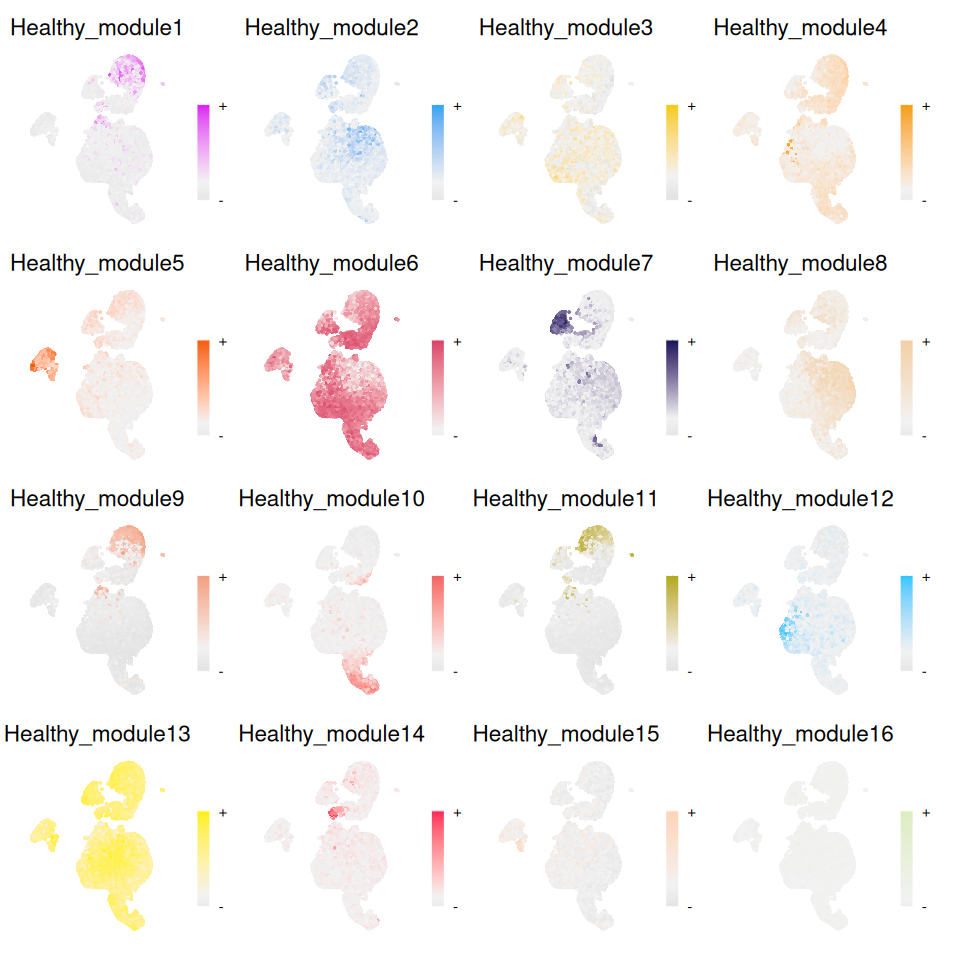

In [39]:
options(repr.plot.width =8, repr.plot.height=8)

# png('./Module_UMAP_AMS.png',width = 8,height = 12,units = 'in',res = 300)
wrap_plots(plot_list, ncol=4)
# dev.off()

In [41]:
Healthy_modules_score[sample(nrow(Healthy_modules_score), nrow(Healthy_modules_score)*0.2),] %>% dim

[1] 15904    16

In [42]:
range(Healthy_modules_score)

[1] -0.9301112  5.8102860

In [43]:
suppressWarnings({

cor_matrix <- cor(Healthy_modules_score[sample(nrow(Healthy_modules_score), nrow(Healthy_modules_score)*0.2),]  , method = "spearman")

p_matrix <- cor.mtest(Healthy_modules_score[sample(nrow(Healthy_modules_score), nrow(Healthy_modules_score)*0.2),]  , method = "spearman")$p

saveRDS(cor_matrix , './02_cor_matrix_AMS.rds')
    
    })

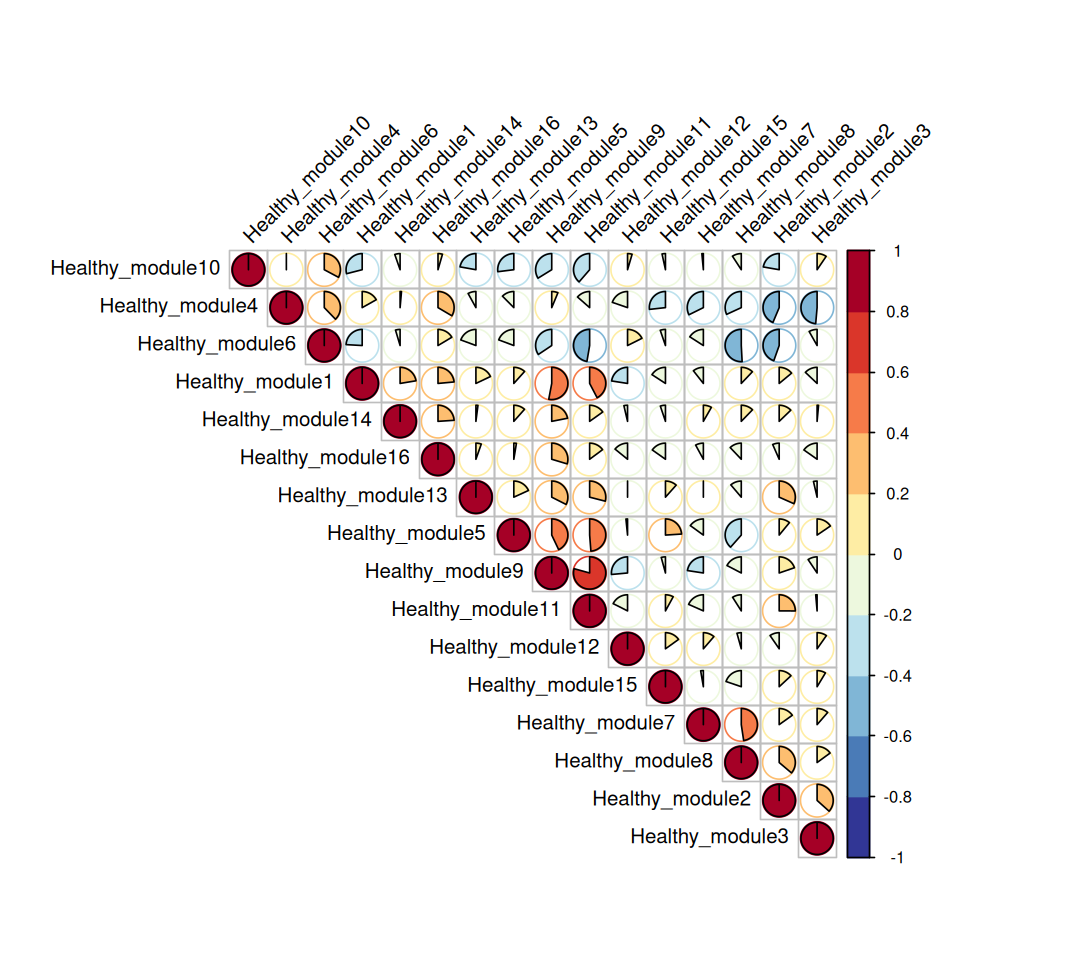

In [47]:
# threshold <- 0.3

# cor_matrix[abs(cor_matrix) <= threshold | p_matrix >= 0.05] <- 0

my_color = rev(paletteer_d("RColorBrewer::RdYlBu"))
my_color = colorRampPalette(my_color)(10) 

# pdf('./02_Heatmap_AMS_1.pdf',width = 8,height = 7)
#  png('./02_Heatmap_AMS_1.png',width = 8,height = 7,units = 'in',res =500)
options(repr.plot.width =9, repr.plot.height=8)

corrplot(cor_matrix, type = "upper", 
         method = "pie",
         order = "hclust", 
         col = my_color,
         tl.col = "black", 
         tl.srt = 45)

# dev.off()

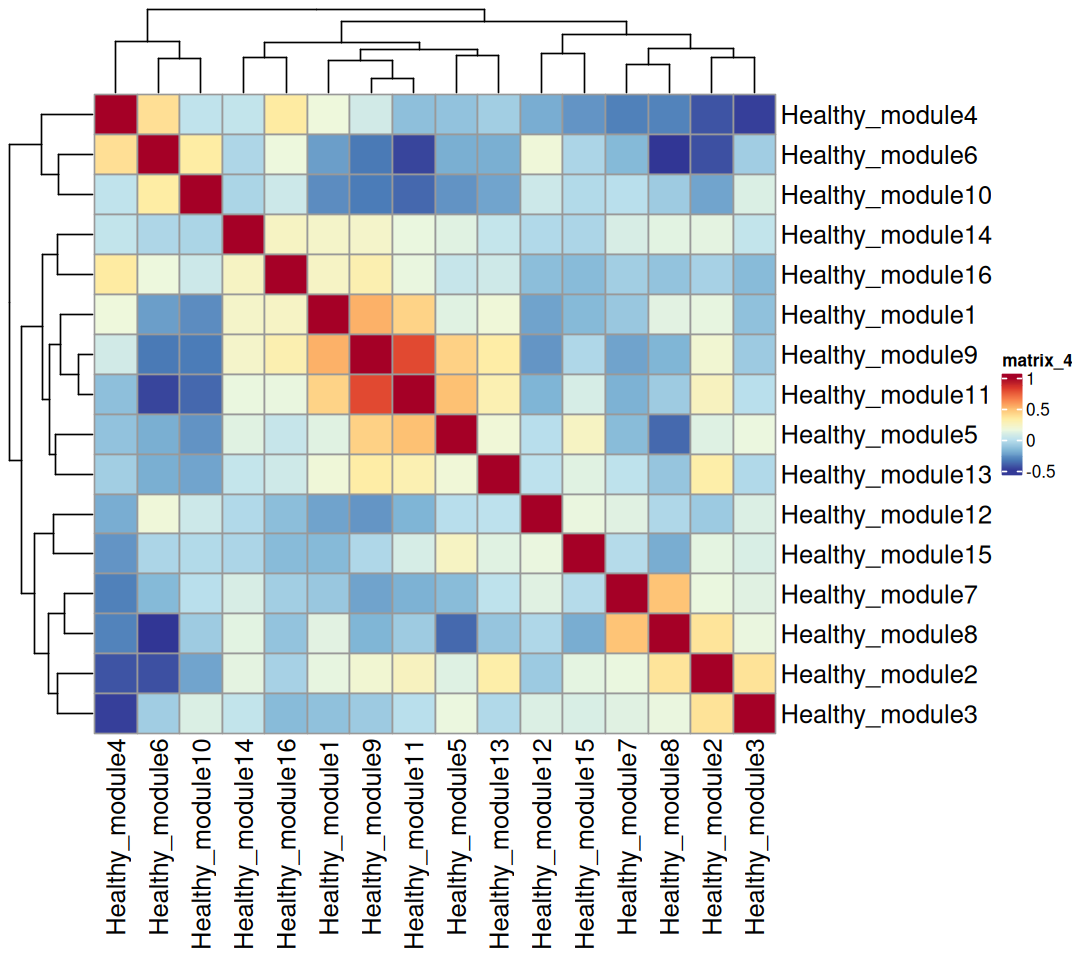

In [51]:
# pdf('./02_Heatmap_AMS_2.pdf',width = 8,height = 7)

# png('./02_Heatmap_AMS_2.png',width = 8,height = 7,units = 'in',res =500)

options(repr.plot.width =9, repr.plot.height=8)

pheatmap(cor_matrix,color =my_color ,fontsize_row = 15,fontsize_col = 15)

# dev.off()

In [52]:
# scatter_df <-cbind( cbind(BE_modules_score,Healthy_modules_score ),AllTissue_merge@meta.data[,c('Tissue_in_paper', 'Detailed_Cell_Type')])
scatter_df <- cbind(BE_modules_score,Healthy_modules_score )

scatter_df <- scatter_df[ sample(x = rownames(scatter_df),size = nrow(scatter_df)*0.2) , c('Tissue_in_paper', 'Detailed_Cell_Type',colnames(Healthy_modules_score) ,colnames(BE_modules_score))]

head(scatter_df)

,Tissue_in_paper,Detailed_Cell_Type,Healthy_module1,Healthy_module2,Healthy_module3,Healthy_module4,Healthy_module5,Healthy_module6,Healthy_module7,Healthy_module8,⋯,BE_module8,BE_module9,BE_module10,BE_module11,BE_module12,BE_module13,BE_module14,BE_module15,BE_module16,BE_module17
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Patient21_SIGAC1_NG-GTTAGTGGTCCTGAAT-1,NGC,Foveolar_Differentiated,-0.16035818,1.1185894,-0.08755825,0.03166539,-0.153479840,0.3450377,-0.0079360910,0.6174221,⋯,-0.14893823,-0.10934506,-0.139147827,0.56047093,0.2589729,-0.2077540,-0.13378040,4.1066655,-0.3034621,1.7430388
GSM3954950-CTAGCCTGTTCCGGCA-1,CAG,Enteroendocrine_GAST,-0.17723217,0.1324936,0.09975233,0.18618108,0.561885151,1.2485834,-0.1147745598,0.3185870,⋯,0.08459791,-0.03141895,0.021379406,-0.05741986,1.2220010,1.0679309,-0.08069870,1.7703607,-0.1269864,0.2165485
GSM3954949-GCTGCTTGTTCGGGCT-1,CAG,Foveolar_Differentiated,-0.07350746,0.9537802,0.81268207,-0.12390584,-0.013834648,0.8086817,-0.0004536998,0.5830521,⋯,0.82622640,-0.01213380,-0.002502483,0.64688399,0.6305384,-0.1857890,-0.02190276,4.1134878,-0.2054348,1.0179806
SRR8513794-ACCAGTATCTTGCAAG-1,Ileum,Enterocytes,0.43063211,-0.1051045,-0.03370296,0.49394318,0.281984533,0.7940008,-0.0055055621,0.1355866,⋯,-0.14849989,-0.09457650,-0.113037029,1.15026891,0.3214806,-0.1189883,-0.05231492,0.2916567,-0.1633984,-0.1332168
GSM3954954-GACGTTAAGGTGCAAC-1,GIM,Foveolar_Differentiated,0.04106881,0.2374589,0.19236967,0.33702454,0.042876593,1.1288168,0.3044925462,1.4271972,⋯,0.11876746,-0.12111867,0.350656568,0.10128345,0.7364386,-0.2124249,0.08458223,2.1505413,-0.1861711,0.3280152
GSM3954950-ACGGAGATCACATAGC-1,CAG,Foveolar_Intermediate,-0.21380253,0.1680371,0.21950874,0.28043294,-0.002149234,1.6096235,0.3073205012,1.0982842,⋯,0.31530280,-0.05113487,0.125052168,0.04046088,1.3770366,-0.1204545,0.14221705,1.9321301,0.0979011,0.5276258


In [35]:
saveRDS(scatter_df , './01_scatter_df_AMS.rds')

In [ ]:
# ggradar(plot_df,group.colours = colors,   draw.points=FALSE,
#       fill=FALSE) + 
#       ggtitle(names(split_df)[1]) + 
#       theme(legend.position = 'left',
# #         plot.title = element_text(face='bold',size = 66,hjust=0.5)
#       )

mycolor <- c('#D916F2','#27A4F2','#F2CB05','#F29F05','#F25C05',
             
             '#D94169','#171559','#F2D0A7','#F29F80','#F26363',
             
             '#B3A815', '#1FC7FF','#FFF005','#FF1F59','#FFD3B6',
             
             '#DCEDC1', '#F24B88','#A8E6CF','#660373','#F28A80'
)


# be_colors <- scales::seq_gradient_pal('#fef5f0', "#990F0F")(seq(0, 1, length.out = sum(grepl("^BE_module", rownames(radar_plot_df)))))

# healthy_colors <- scales::seq_gradient_pal("#cac5e4", "#260F99")(seq(0, 1, length.out = sum(grepl("^Healthy", rownames(radar_plot_df)))))
 
# colors <- c(healthy_colors , be_colors)

colors <- data.frame('modules' =cbind(c ,BE_modules_score)[,-c(1,2)] %>% colnames ,'colors' =rep(mycolor,2))

In [43]:
radar_plot_list  <-split(scatter_df ,scatter_df$Tissue_in_paper)

In [44]:
head(radar_plot_list[[1]])

,Tissue_in_paper,Detailed_Cell_Type,Healthy_module1,Healthy_module2,Healthy_module3,Healthy_module4,Healthy_module5,Healthy_module6,Healthy_module7,Healthy_module8,⋯,BE_module8,BE_module9,BE_module10,BE_module11,BE_module12,BE_module13,BE_module14,BE_module15,BE_module16,BE_module17
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Patient09_SIGAF9_BE-CCGGGATGTACCGTTA-1,BE-IM,Enterocytes_Intermediate,-0.2323559,1.0539788,0.22192823,0.4138138,0.012364360,0.12995677,-0.03454818,0.7184277,⋯,0.1893133,-0.11900432,0.1111629361,0.21580322,0.4395879,0.02194118,0.22183825,3.095187,-0.01161667,0.86484808
Patient19_SIGAB3_BE-GTAGAAACAACAACAA-1,BE-IM,Intestinal_Undifferentiated,-0.3092988,0.1518703,-0.04050166,0.4182369,-0.135818400,0.01455857,-0.15369905,1.9083468,⋯,-0.2134191,-0.04248613,-0.0023122062,-0.39948365,2.1190083,-0.15303789,0.01508075,2.469471,0.09623880,-0.09488037
Patient07_SIGAC4_BE-AACTCTTAGGGTCTCC-1,BE-IM,Enterocytes_Intermediate,-0.3472630,0.6247764,-0.16722532,0.5640102,-0.387674696,0.01609194,-0.20522179,1.4072031,⋯,-0.4920692,0.48547761,0.7950570452,-0.32182554,1.3979998,-0.18927802,0.30445659,2.019542,-0.00403856,0.11162891
Patient19_SIGAB3_BE-GTTTGGAAGTCATTGC-1,BE-IM,Intestinal_Undifferentiated,-0.2823946,0.1674590,-0.14259657,0.4130173,-0.573681748,-0.01558397,-0.13913226,1.8481915,⋯,-0.3711374,-0.05096485,0.0001763276,-0.38986785,2.0859455,-0.24921412,-0.12649897,3.213677,0.01406058,-0.15495790
Patient19_SIGAB3_BE-CGAGAAGTCGATCCAA-1,BE-IM,Enterocytes_Intermediate,-0.4636152,0.5579877,-0.12583516,0.5440386,0.056152103,0.01020064,-0.06771300,1.4680320,⋯,-0.4046230,-0.08739548,0.0138814168,-0.06076222,1.5141173,-0.17485351,-0.08156853,2.599030,0.07215577,0.06064860
Patient03_SIGAC5_BE-GCTGCAGCAAGACGTG-1,BE-IM,Enterocytes_Intermediate,-0.1849584,0.3827824,0.23452664,0.2972957,0.008350116,0.12337739,0.08138495,1.2324082,⋯,0.2582586,-0.05060268,0.0279013595,0.19402139,1.1340170,-0.19758356,0.18482833,3.478699,0.02040023,0.99269457


In [45]:
 radar_plot_df <- radar_plot_list[[1]][, -1] %>% 
    dplyr::group_by(Detailed_Cell_Type) %>% 
    dplyr::summarise_all(mean) %>%
    as.data.frame() 


Warning message:
“There were 16 warnings in `summarise()`.
The first warning was:
ℹ In argument: `Tissue_in_paper.1 = (new("standardGeneric", .Data = function (x, ...) ...`.
ℹ In group 1: `Detailed_Cell_Type = "Enterocytes"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 15 remaining warnings.”


In [47]:

rownames(radar_plot_df) <- radar_plot_df$Detailed_Cell_Type

radar_plot_df <- dplyr::select(radar_plot_df, -Detailed_Cell_Type) 

radar_plot_df <- t(radar_plot_df) %>% as.data.frame()

radar_plot_df[radar_plot_df < 0] <- 0 

radar_plot_df$module <- rownames(radar_plot_df)

  radar_plot_df <- radar_plot_df[,c('module', colnames(radar_plot_df)[1:ncol(radar_plot_df)-1])]

In [48]:
head(radar_plot_df)

,module,Enterocytes,Enterocytes_Intermediate,Enteroendocrine_CHGA,Foveolar_Differentiated,Foveolar_Intermediate,Goblet,Intestinal_Undifferentiated,Neck-Cells
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Healthy_module1,Healthy_module1,0.0000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Healthy_module2,Healthy_module2,0.0000000,0.65666447,0.1098682,1.05073944,0.61307957,0.35348368,0.15822738,0.13610152
Healthy_module3,Healthy_module3,0.0000000,0.00000000,0.0000000,0.10283511,0.00000000,0.03399712,0.00000000,0.00000000
Healthy_module4,Healthy_module4,0.0000000,0.51159331,0.3412695,0.19995906,0.44759467,0.28525322,0.49098086,0.40982942
Healthy_module5,Healthy_module5,0.0000000,0.00000000,0.0000000,0.13298963,0.00000000,0.00000000,0.00000000,0.00000000
Healthy_module6,Healthy_module6,0.1613644,0.04708526,0.4963517,0.05369041,0.00980189,0.10607163,0.01561966,0.08200475


In [51]:

cor_matrix <- cor(module_data , method = "spearman")
p_matrix <- cor.mtest(module_data , method = "spearman")$p

threshod <- 0.6
cor_matrix[abs(cor_matrix) <= threshold | p_matrix >= 0.05] <- 0

my_color = rev(paletteer_d("RColorBrewer::RdYlBu"))
my_color = colorRampPalette(my_color)(10) 


function (object, features, pool = NULL, nbin = 24, ctrl = 100, 
    k = FALSE, assay = NULL, name = "Cluster", seed = 1, search = FALSE, 
    slot = "data", ...) 
{
    if (!is.null(x = seed)) {
        set.seed(seed = seed)
    }
    assay.old <- DefaultAssay(object = object)
    assay <- assay %||% assay.old
    DefaultAssay(object = object) <- assay
    assay.data <- GetAssayData(object = object, assay = assay, 
        slot = slot)
    features.old <- features
    if (k) {
        .NotYetUsed(arg = "k")
        features <- list()
        for (i in as.numeric(x = names(x = table(object@kmeans.obj[[1]]$cluster)))) {
            features[[i]] <- names(x = which(x = object@kmeans.obj[[1]]$cluster == 
                i))
        }
        cluster.length <- length(x = features)
    }
    else {
        if (is.null(x = features)) {
            stop("Missing input feature list")
        }
        features <- lapply(X = features, FUN = function(x) {
            missing.features <- setdiff(x = x, y = rownames(x = object))
            if (length(x = missing.features) > 0) {
                warning("The following features are not present in the object: ", 
                  paste(missing.features, collapse = ", "), ifelse(test = search, 
                    yes = ", attempting to find updated synonyms", 
                    no = ", not searching for symbol synonyms"), 
                  call. = FALSE, immediate. = TRUE)
                if (search) {
                  tryCatch(expr = {
                    updated.features <- UpdateSymbolList(symbols = missing.features, 
                      ...)
                    names(x = updated.features) <- missing.features
                    for (miss in names(x = updated.features)) {
                      index <- which(x == miss)
                      x[index] <- updated.features[miss]
                    }
                  }, error = function(...) {
                    warning("Could not reach HGNC's gene names database", 
                      call. = FALSE, immediate. = TRUE)
                  })
                  missing.features <- setdiff(x = x, y = rownames(x = object))
                  if (length(x = missing.features) > 0) {
                    warning("The following features are still not present in the object: ", 
                      paste(missing.features, collapse = ", "), 
                      call. = FALSE, immediate. = TRUE)
                  }
                }
            }
            return(intersect(x = x, y = rownames(x = object)))
        })
        cluster.length <- length(x = features)
    }
    if (!all(LengthCheck(values = features))) {
        warning(paste("Could not find enough features in the object from the following feature lists:", 
            paste(names(x = which(x = !LengthCheck(values = features)))), 
            "Attempting to match case..."))
        features <- lapply(X = features.old, FUN = CaseMatch, 
            match = rownames(x = object))
    }
    if (!all(LengthCheck(values = features))) {
        stop(paste("The following feature lists do not have enough features present in the object:", 
            paste(names(x = which(x = !LengthCheck(values = features)))), 
            "exiting..."))
    }
    pool <- pool %||% rownames(x = object)
    data.avg <- Matrix::rowMeans(x = assay.data[pool, ])
    data.avg <- data.avg[order(data.avg)]
    data.cut <- cut_number(x = data.avg + rnorm(n = length(data.avg))/1e+30, 
        n = nbin, labels = FALSE, right = FALSE)
    names(x = data.cut) <- names(x = data.avg)
    ctrl.use <- vector(mode = "list", length = cluster.length)
    for (i in 1:cluster.length) {
        features.use <- features[[i]]
        for (j in 1:length(x = features.use)) {
            ctrl.use[[i]] <- c(ctrl.use[[i]], names(x = sample(x = data.cut[which(x = data.cut == 
                data.cut[features.use[j]])], size = ctrl, replace = FALSE)))
        }
    }
    ctrl.use <- lapply(X = ctrl.use, FUN = unique)
    ctrl.scores